In [1]:
import pandas as pd
import datetime
import numpy as np
from tqdm import tqdm_notebook
from datetime import datetime,timedelta
import os
from timeit import default_timer as timer
from scipy import stats
from sklearn import linear_model
os.chdir('/Users/hudsonyeo/Desktop/Python/leo/data/day/TA')
file_list=os.listdir('/Users/hudsonyeo/Desktop/Python/leo/data/day/TA')
file_list.sort()

In [2]:
file_list

['.DS_Store',
 '2019.01.02.csv',
 '2019.01.03.csv',
 '2019.01.04.csv',
 '2019.01.07.csv',
 '2019.01.08.csv',
 '2019.01.09.csv',
 '2019.01.10.csv',
 '2019.01.11.csv',
 '2019.01.14.csv',
 '2019.01.15.csv',
 '2019.01.16.csv',
 '2019.01.17.csv',
 '2019.01.18.csv',
 '2019.01.21.csv',
 '2019.01.22.csv',
 '2019.01.23.csv',
 '2019.01.24.csv',
 '2019.01.25.csv',
 '2019.01.28.csv',
 '2019.01.29.csv',
 '2019.01.30.csv',
 '2019.01.31.csv',
 '2019.02.01.csv',
 '2019.02.11.csv',
 '2019.02.12.csv',
 '2019.02.13.csv',
 '2019.02.14.csv',
 '2019.02.15.csv',
 '2019.02.18.csv',
 '2019.02.19.csv',
 '2019.02.20.csv',
 '2019.02.21.csv',
 '2019.02.22.csv',
 '2019.02.25.csv',
 '2019.02.26.csv',
 '2019.02.27.csv',
 '2019.02.28.csv',
 '2019.03.01.csv',
 '2019.03.04.csv',
 '2019.03.05.csv',
 '2019.03.06.csv',
 '2019.03.07.csv',
 '2019.03.08.csv',
 '2019.03.11.csv',
 '2019.03.12.csv',
 '2019.03.13.csv',
 '2019.03.14.csv',
 '2019.03.15.csv',
 '2019.03.18.csv',
 '2019.03.19.csv',
 '2019.03.20.csv',
 '2019.03.21.csv'

In [5]:
class categorise():
    def __init__(self):
        self.threshold=[]
        self.percentiles=[25,50,75]
        
    def fit(self,array):
        positive=array[array>0]
        negative=array[array<0]
        self.threshold.append(np.percentile(negative,self.percentiles))   
        self.threshold.append(np.percentile(positive,self.percentiles))
     
    def return_quartile(self,array):
        temp=[]
        for i in array:
            if i>=0:
                if i<self.threshold[1][0]:
                    temp.append(5)
                elif i<self.threshold[1][1]:
                    temp.append(6)
                elif i<self.threshold[1][2]:
                    temp.append(7)
                else:
                    temp.append(8)
            if i<0:
                if i>self.threshold[0][2]:
                    temp.append(4)
                elif i>self.threshold[0][1]:
                    temp.append(3)
                elif i>self.threshold[0][0]:
                    temp.append(2)
                else:
                    temp.append(1)
        return np.asarray(temp)
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                     n_jobs=1):
            self.fit_intercept = fit_intercept
            self.normalize = normalize
            self.copy_X = copy_X
            self.n_jobs = n_jobs
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])
                    ])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self                    

In [61]:
def calc_smart_price(dataset):
    data=dataset[:]
    
    #to combat the limit up event, where price is set to 0. 
    rows=(data.loc[:,'BidPrice1']==0) #count rows of bid price equal 0
    if (np.any(rows)): #if there is such a row
        data.at[rows,'BidPrice1']=data.loc[rows,'AskPrice1'] #for that row, assign ask price to it
    rows=(data.loc[:,'AskPrice1']==0) #do the same for ask price
    if (np.any(rows)):
        data.at[rows,'AskPrice1']=data.loc[rows,'BidPrice1'] 
        
    data['smart_price']=data.loc[:,'BidPrice1']*data.loc[:,'AskVol1']+data.loc[:,'AskPrice1']*data.loc[:,'BidVol1']
    data.at[:,'smart_price']=data.loc[:,'smart_price']/(data.loc[:,['BidVol1','AskVol1']].sum(axis=1))  
    return data

def calc_future_price(dataset,time_ahead=30):
    data=dataset[:]
    future_price=[]
    length=len(data)
    for i in range(len(data)):
        current_time=data[i,44]+timedelta(seconds=time_ahead)
        #print(data[i,44])
        j=0
        #print(current_time)
        while((i+j)<length and current_time>data[(i+j),44]):
            j+=1
        #print(i,j,(data[(i+j-1),44]))
        if (i+j)<length:
            future_price.append(data[(i+j),51]) #51 is the index for smart price            
        else:
            future_price.append(np.nan)
    future_price=np.asarray(future_price)
    future_price=np.expand_dims(future_price,axis=1)
    return np.concatenate((data,future_price),axis=1)


def calc_edge(dataset):
    data=dataset.copy()
    temp=data[:,52]-data[:,51]
    temp=np.expand_dims(temp,axis=1)
    return np.concatenate((data,temp),axis=1)

def set_index(dataset):
    data=dataset[:]
    index=data[:,44]
    new_index=[]
    for j in range(len(index)):
        i=str(index[j]*1000)
        if len(i)==11:
            i='0'+i
        i=i[:-10]+':'+i[-10:]
        i=i[:-8]+':'+i[-8:]
        i=i[:-6]+':'+i[-6:]
        new_index.append(datetime.strptime(i,"%H:%M:%S:%f"))
    data[:,44]=new_index
    return data
def calc_sma(dataset,duration=1): #not in use, just for reference
    #5 seconds for 5000 rows
    data=dataset[:]
    sma_values=[]

    for i in data[:,44]:
        last_time=i-timedelta(minutes=duration)
        sma=data[(data[:,44]>=last_time) & (data[:,44]<i)]
        if len(sma)!=0:
            sma=sma[:,51].mean()
        else:
            sma=np.nan
        sma_values.append(sma)
    sma_values=np.asarray(sma_values)
    sma_values=np.expand_dims(sma_values,axis=1)
    return np.concatenate((data,sma_values),axis=1)
def calc_sma_fast(dataset,duration=1): #faster way to calculate SMA, 0.05 seconds for 5000 rows
    data=dataset[:]
    sma_values=[] 
    smart_sum=np.cumsum(data[:,51])
    for i in range(len(data)):
        last_time=data[i,44]-timedelta(minutes=duration)
        j=220*duration#4x60=240
        while(i-j>0 and data[i-j,44]>last_time):
            j+=1
        if (i-j>=0):
            sma=(smart_sum[i]-smart_sum[i-j])/(j)
            sma_values.append(sma)
        else:
            sma=smart_sum[i]/(i+1)
            sma_values.append(sma)

    sma_values=np.asarray(sma_values)
    sma_values=data[:,51]-sma_values
    sma_values=np.expand_dims(sma_values,axis=1)
    return np.concatenate((data,sma_values),axis=1)        

def calc_sma_binary(dataset,duration=1): #faster way to calculate SMA, 0.05 seconds for 5000 rows
    data=dataset[:]
    sma_values=[] 
    smart_sum=np.cumsum(data[:,51])
    for i in range(len(data)):
        last_time=data[i,44]-timedelta(minutes=duration)
        j=220*duration#4x60=240
        while(i-j>0 and data[i-j,44]>last_time):
            j+=1
        if (i-j>=0):
            sma=(smart_sum[i]-smart_sum[i-j])/(j)
            sma_values.append(sma)
        else:
            sma=smart_sum[i]/(i+1)
            sma_values.append(sma)

    sma_values=np.asarray(sma_values)
    sma_values=data[:,51]-sma_values
    sma_values[sma_values>=0]=1
    sma_values[sma_values<0]=-1
    sma_values=np.expand_dims(sma_values,axis=1)
    return np.concatenate((data,sma_values),axis=1)   

def process(dataset):
    data=dataset[:]
    data=calc_smart_price(data).values #51
    data=set_index(data)
    data=calc_future_price(data) #52
    data=calc_edge(data) #53
    data=calc_sma_fast(data,duration=1) #54
    data=calc_sma_fast(data,duration=5) #55
    data=calc_sma_fast(data,duration=15) #56
    data=calc_sma_fast(data,duration=30) #57
    return data
ma_dict={'-4':'1',
        '-3':'5',
        '-2':'15',
        '-1':'30',
        '54':'1',
        '55':'5',
        '56':'15',
        '57':'30'}    
 

'def calc_vwap(dataset,duration=1): #to be implement\n    data=dataset[:]\n    for i in data[:,44]:\n        last_time=i-timedelta(minutes=duration)\n        rolling=data[(data[:,44]>=last_time) & (data[:,44]<i)]\n        high=rolling[:,51].max()\n        low=rolling[:,51].min()\n        avg=(rolling[-1,51]+high+low)/3\ndef calc_rsi(dataset)        '

In [8]:
#process files to get technical indicators
#add all files to a dataframe called df_list
df_list=[]
name_list=[]
path='/Users/hudsonyeo/Desktop/Python/leo/data/day/TA/'
for file in file_list: #read all files and add them to file_list
    if file[-3:]=='csv': #check if file is a CSV
        name_list.append(file)
        df_list.append(process(pd.read_csv(path+file)))
        print(file,'read')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2019.01.02.csv read
2019.01.03.csv read
2019.01.04.csv read
2019.01.07.csv read
2019.01.08.csv read
2019.01.09.csv read
2019.01.10.csv read
2019.01.11.csv read
2019.01.14.csv read
2019.01.15.csv read
2019.01.16.csv read
2019.01.17.csv read
2019.01.18.csv read
2019.01.21.csv read
2019.01.22.csv read
2019.01.23.csv read
2019.01.24.csv read
2019.01.25.csv read
2019.01.28.csv read
2019.01.29.csv read
2019.01.30.csv read
2019.01.31.csv read
2019.02.01.csv read
2019.02.11.csv read
2019.02.12.csv read
2019.02.13.csv read
2019.02.14.csv read
2019.02.15.csv read
2019.02.18.csv read
2019.02.19.csv read
2019.02.20.csv read
2019.02.21.csv read
2019.02.22.csv read
2019.02.25.csv read
2019.02.26.csv read
2019.02.27.csv read
2019.02.28.csv read
2019.03.01.csv read
2019.03.04.csv read
2019.03.05.csv read
2019.03.06.csv read
2019.03.07.csv read
2019.03.08.csv read
2019.03.11.csv read
2019.03.12.csv read
2019.03.13.csv read
2019.03.14.csv read
2019.03.15.csv read
2019.03.18.csv read
2019.03.19.csv read


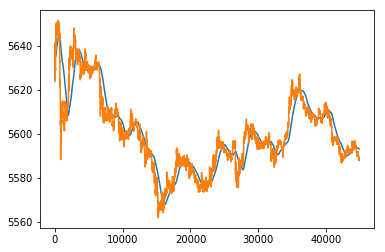

In [34]:
#visualisation of SMA
import matplotlib.pyplot as plt
#plt.plot(df_list[0][:,51])
plt.plot(df_list[0][:,51]-df_list[0][:,55])
plt.plot(df_list[0][:,51])
#plt.plot(df_list[0][5000:5100,55])
#plt.plot(df_list[0][5000:5100,56])
#plt.plot(df_list[0][5000:5100,57])

In [17]:
#compute results
df_path='/Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/'

num_days=4
for j in [54,55,56,57]: #for each column of moving average
    
    final_df=pd.DataFrame()    
    print(j,ma_dict.get(str(j)),'ma')    

    for i in range(len(df_list)): #for each 20 day rolling window
        if i<19:
            continue
        print(name_list[i])
        #get -19 day
        x=df_list[i-19][:,j]
        #get -18 to 0 day (19 days in total)
        for k in range((i-18),i+1): #get 20 day moving averages
            x=np.concatenate((x,df_list[k][:,j]))

        cat=categorise()
        cat.fit(x) #calculate quartile thresholds for past 20 days
        
        #get x,y for regression
        x=df_list[i][:,j] #column for SMA
        x=x.astype(float)        
        y=df_list[i][:,53] #column for edge
        y=y.astype(float)
        
        #removing all NA
        isnum=(~np.isnan(x)) & (~np.isnan(y))
        y=y[isnum]
        x=x[isnum]        
        
        #get the quartiles of the SMA
        category=cat.return_quartile(x)
        
        reg_result={}
        reg_result['ma_time_minutes']=ma_dict.get(str(j))
        reg_result['date']=name_list[i]
        reg_result['total_obs']=len(x)
        
        for quartile in range(1,9):
            
            #filter by quartile
            filtered=(category==quartile) 
            q='quartile_'+str(quartile)+'_'
            if (np.any(filtered)):
                new_x=x[filtered]
                new_y=y[filtered] 
                new_x=np.expand_dims(new_x,1)
                new_y=np.expand_dims(new_y,1)
                lin_model=LinearRegression(fit_intercept=False)
                lin_model.fit(new_x,new_y)
                
                reg_result[(q+'slope')]=lin_model.coef_[0][0]

                reg_result[(q+'p_val')]=lin_model.p[0][0]
                reg_result[(q+'x_mean')]=np.mean(new_x)
                reg_result[(q+'x_std')]=np.std(new_x)
                reg_result[(q+'num_obs')]=len(new_x)

            else:
                reg_result[(q+'slope')]='na'

                reg_result[(q+'p_val')]='na'
                reg_result[(q+'x_mean')]='na'
                reg_result[(q+'x_std')]='na'
                reg_result[(q+'num_obs')]='0'
                
        final_df=final_df.append(reg_result,ignore_index=True)                
    temp=df_path+'result_1day_8split_'+ma_dict.get(str(j))+'minute_ma_nointercept.csv'
    final_df.to_csv(temp)
    print('done',temp)

54 1 ma
starting 10: 20
starting 10: 30
starting 10: 40
starting 10: 50
starting 10: 60
starting 10: 70
starting 10: 80
done /Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/result_1day_8split_1minute_ma_nointercept.csv
55 5 ma
starting 10: 20
starting 10: 30
starting 10: 40
starting 10: 50
starting 10: 60
starting 10: 70
starting 10: 80
done /Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/result_1day_8split_5minute_ma_nointercept.csv
56 15 ma
starting 10: 20
starting 10: 30
starting 10: 40
starting 10: 50
starting 10: 60
starting 10: 70
starting 10: 80
done /Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/result_1day_8split_15minute_ma_nointercept.csv
57 30 ma
starting 10: 20
starting 10: 30
starting 10: 40
starting 10: 50
starting 10: 60
starting 10: 70
starting 10: 80
done /Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/result_1day_8split_30minute_ma_nointercept.csv


In [60]:
data=pd.read_csv('/Users/hudsonyeo/Desktop/Python/leo/data/day/TA/results/result_1day_8split_1minute_ma_nointercept.csv')
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
for i in range(1,9):
    col='quartile_'+str(i)+'_slope'
    row=data.loc[:,col]
    x=[]
    for j in row:
        if is_number(j) and j==j:
            k=float(j)
            #print(k)
            x.append(k)

            
    x=np.asarray(x)
    pos=x[x>0]
    perc=len(pos)/len(x)
    print('category:',i,'percentage positive:',round(perc,7),'mean slope:',round(row.mean(),7),'std dev',round(row.std(),7))

category: 1 percentage positive: 0.4375 mean slope: -0.0033724 std dev 0.0945388
category: 2 percentage positive: 0.6875 mean slope: 0.0745046 std dev 0.1524134
category: 3 percentage positive: 0.78125 mean slope: 0.1540754 std dev 0.251565
category: 4 percentage positive: 0.828125 mean slope: 0.4475493 std dev 0.6785362
category: 5 percentage positive: 0.625 mean slope: 0.1432101 std dev 0.6723224
category: 6 percentage positive: 0.609375 mean slope: 0.1121168 std dev 0.2269826
category: 7 percentage positive: 0.6875 mean slope: 0.0815322 std dev 0.1425369
category: 8 percentage positive: 0.5625 mean slope: 0.0249555 std dev 0.0997902
